## Binary-tree prefix-sum mechanism (Laplace)
This class mirrors the `CummuNoiseTorch` binary-tree aggregation logic, but uses NumPy and Laplace noise with scale `1/epsilon`.
Noise is truncated to `±4*(log(L)*(log(L)+log(2/delta)))/epsilon` before being added to each prefix sum.


In [1]:
import numpy as np

class CummuNoiseLaplaceNP:
    """Binary-tree prefix-sum mechanism with Laplace noise (scale = 1/epsilon)."""

    def __init__(self, rng=None):
        self.rng = np.random.default_rng() if rng is None else rng
        self.reset()

    def reset(self, shape=None):
        self.shape = shape
        self.step = 0
        self.binary = [0]
        self.noise_sum = None
        self.recorded = None
        if shape is not None:
            self.noise_sum = np.zeros(shape, dtype=float)
            self.recorded = [np.zeros(shape, dtype=float)]

    def _ensure_state(self, shape):
        if self.noise_sum is None or self.shape != shape:
            self.reset(shape)

    def _sample_noise(self, epsilon):
        scale = 1.0 / float(epsilon)
        return self.rng.laplace(0.0, scale, size=self.shape)

    def _next_noise(self, epsilon):
        self.step += 1

        idx = 0
        while idx < len(self.binary) and self.binary[idx] == 1:
            self.binary[idx] = 0
            self.noise_sum -= self.recorded[idx]
            idx += 1
        if idx >= len(self.binary):
            self.binary.append(0)
            self.recorded.append(np.zeros(self.shape, dtype=float))

        n = np.asarray(self._sample_noise(epsilon), dtype=float)
        self.noise_sum += n
        self.recorded[idx] = n
        self.binary[idx] = 1
        return np.array(self.noise_sum, copy=True)

    def compute(self, length, stream, epsilon, delta):
        if length <= 0:
            raise ValueError("length must be positive")
        if epsilon <= 0:
            raise ValueError("epsilon must be positive")
        if delta <= 0 or delta >= 1:
            raise ValueError("delta must be in (0, 1)")

        data = np.asarray(stream, dtype=float)
        if data.shape[0] != int(length):
            raise ValueError("length does not match stream length")

        shape = data.shape[1:]
        self._ensure_state(shape)

        log_l = np.log(float(length))
        threshold = 4.0 * (log_l * (log_l + np.log(2.0 / float(delta)))) / float(epsilon)

        outputs = np.empty_like(data, dtype=float)
        prefix = np.zeros(shape, dtype=float)
        for t in range(int(length)):
            prefix = prefix + data[t]
            noise = self._next_noise(epsilon)
            #noise = np.clip(noise, -threshold, threshold)
            outputs[t] = prefix + noise
        return outputs

    def __call__(self, length, stream, epsilon, delta):
        return self.compute(length, stream, epsilon, delta)


In [2]:
# Test the class: sum from 0 to 100
import numpy as np

stream = np.arange(0, 101, dtype=float)
L = len(stream)
true_prefix = np.cumsum(stream)

# Small noise (epsilon relatively small)
cn_small = CummuNoiseLaplaceNP()
noisy_small = cn_small.compute(L, stream, epsilon=1.0, delta=1e-6)

# Nearly no noise (epsilon very large)
cn_none = CummuNoiseLaplaceNP()
noisy_none = cn_none.compute(L, stream, epsilon=1e9, delta=1e-6)

print('True last prefix:', true_prefix[-1])
print('Small-noise last prefix:', noisy_small[-1])
print('No-noise last prefix:', noisy_none[-1])
print('Small-noise max abs error:', np.max(np.abs(noisy_small - true_prefix)))
print('No-noise max abs error:', np.max(np.abs(noisy_none - true_prefix)))


True last prefix: 5050.0
Small-noise last prefix: 5047.523404714657
No-noise last prefix: 5049.9999999997735
Small-noise max abs error: 5.3020878379475676
No-noise max abs error: 5.6020326155703515e-09


## Interactive randbin mechanism
Implementation of Algorithm 1 using the truncated geometric sampler from `dp_data.py` and the Laplace-based prefix-sum mechanism above.
The output uses `None` to represent $\bot$.


In [3]:
import math
import numpy as np

def sample_truncated_geometric(epsilon, delta, rng=None):
    if epsilon <= 0:
        raise ValueError("epsilon must be > 0")
    if not (0 < delta < 1):
        raise ValueError("delta must be in (0, 1)")

    alpha = math.exp(epsilon)
    u_bound = math.log(2 / delta) / epsilon

    p = 1 - 1 / alpha
    p = max(1e-10, min(1 - 1e-10, p))

    rng = np.random.default_rng() if rng is None else rng
    magnitude = int(rng.geometric(p) - 1)
    sign = -1 if rng.random() < 0.5 else 1
    r = sign * magnitude

    r = max(-u_bound, min(u_bound, r))
    return int(r)

from collections import deque



def _u_bound(epsilon, delta):
    return 2*math.log(2.0 / delta) / epsilon


def _sample_C(epsilon1, delta1, U):
    # Distribution: 3U/2 + G(epsilon1, delta1), clamped to [U, 2U].
    r = sample_truncated_geometric(epsilon1, delta1)
    c = int(round(1.5 * U + r))
    c = max(U, min(2 * U, c))
    return c


def _E(i, epsilon, delta):
    if i <= 1:
        return 0.0
    logi = math.log(i)
    return 4.0 * (logi * (logi + math.log(2.0 / delta))) / epsilon


class InteractivePrefixSum:
    def __init__(self, epsilon, delta):
        self.epsilon = float(epsilon)
        self.delta = float(delta)
        self.mechanism = CummuNoiseLaplaceNP()
        self.prefix = 0.0
        self.step = 0

    def add(self, value):
        self.prefix += float(value)
        self.step += 1
        self.mechanism._ensure_state(())
        noise = self.mechanism._next_noise(self.epsilon)
        bound = _E(self.step, self.epsilon, self.delta)
        noise = float(np.clip(noise, -bound, bound))
        return self.prefix + noise


def interactive_randbin(epsilon, delta, stream):
    eps1 = epsilon / 2.0
    eps2 = epsilon / 2.0
    del1 = delta / 2.0
    del2 = delta / 2.0

    U = int(math.ceil(_u_bound(eps1, del1)))

    presum = InteractivePrefixSum(eps2, del2)
    buf = deque()

    ind = 1
    C = [0]
    S = [0.0]

    c1 = _sample_C(eps1, del1, U)
    C.append(c1)
    S.append(presum.add(c1))

    outputs = []
    backlog = []
    for t, x in enumerate(stream, start=1):
        buf.append(x)

        if t < S[ind] + _E(ind, eps2, del2) + 2 * U:
            outputs.append(None)  # ⊥
            backlog.append(len(buf))
            continue

        count = C[ind]
        bin_items = []
        for _ in range(count):
            if not buf:
                break
            bin_items.append(buf.popleft())

        outputs.append(bin_items)
        backlog.append(len(buf))

        ind += 1
        c_new = _sample_C(eps1, del1, U)
        C.append(c_new)
        S.append(presum.add(c_new))

    return outputs, backlog


In [4]:
# Test the interactive randbin mechanism
import numpy as np

stream = list(range(1, 201))
outputs = interactive_randbin(epsilon=1.0, delta=1e-6, stream=stream)

num_bot = sum(1 for o in outputs if o is None)
num_bins = sum(1 for o in outputs if o is not None)

print('Total steps:', len(outputs))
print('Bins produced:', num_bins)
print('⊥ outputs:', num_bot)

# Show first few non-empty bins
bins = [o for o in outputs if o is not None]
print('First 3 bins:', bins[:3])
print('First bin size:', len(bins[0]) if bins else 0)


Total steps: 2
Bins produced: 2
⊥ outputs: 0
First 3 bins: [[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

epsilon=0.5, delta=1e-06: bins=100, mean_backlog=1396.49
epsilon=1.0, delta=1e-06: bins=206, mean_backlog=834.69
epsilon=2.0, delta=1e-06: bins=420, mean_backlog=492.65
epsilon=4.0, delta=1e-06: bins=819, mean_backlog=282.90


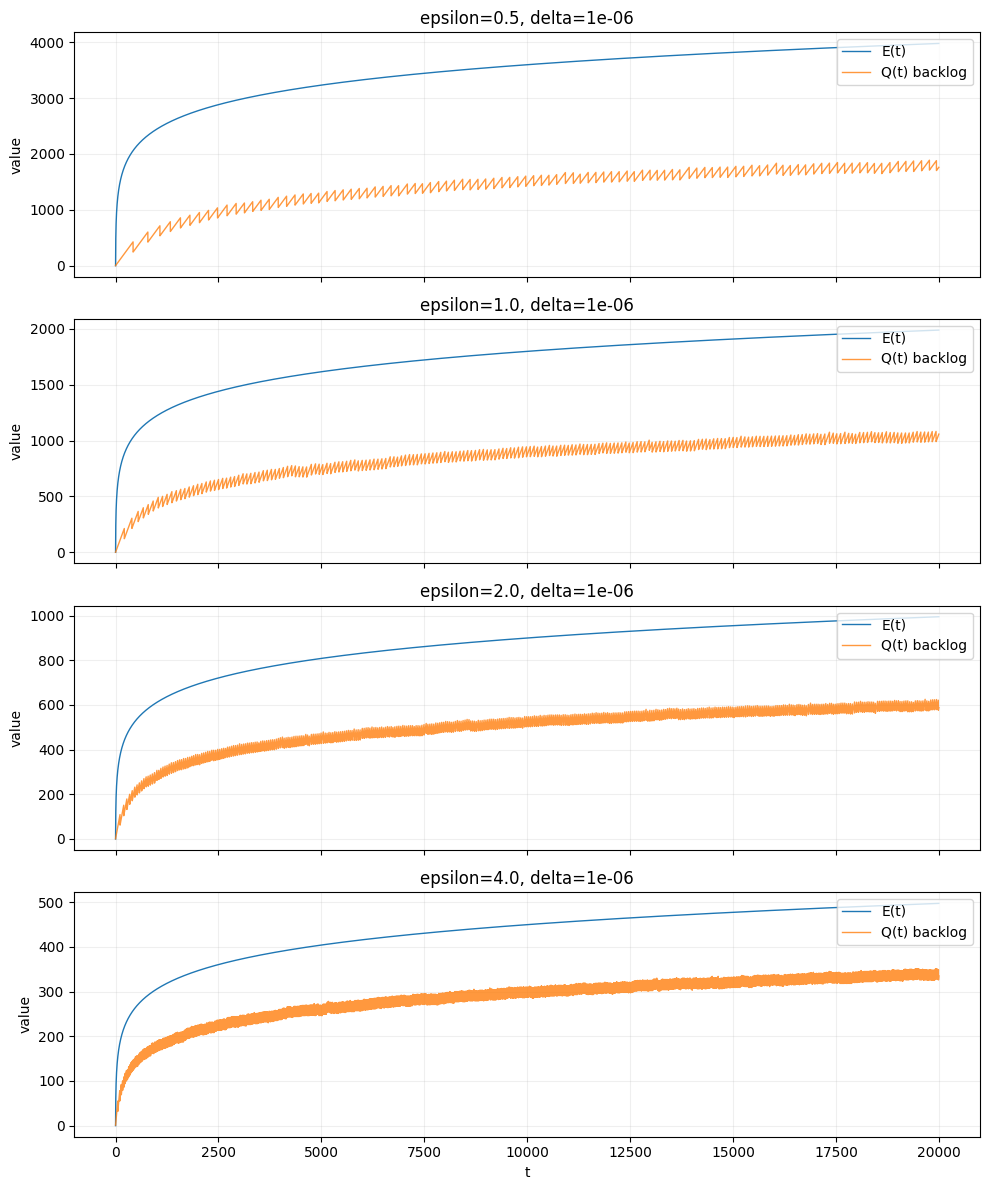

In [6]:
# Visualize E(t) vs Q(t) for multiple (epsilon, delta) pairs
import numpy as np
import matplotlib.pyplot as plt




def _compute_E_curve(T, epsilon, delta):
    eps2 = epsilon / 2.0
    del2 = delta / 2.0
    return np.array([_E(t + 1, eps2, del2) for t in range(T)], dtype=float)


# Configure experiments
T = 20000
stream = list(range(1, T + 1))
params = [
    (0.5, 1e-6),
    (1.0, 1e-6),
    (2.0, 1e-6),
    (4.0, 1e-6),
]

fig, axes = plt.subplots(len(params), 1, figsize=(10, 3 * len(params)), sharex=True)
if len(params) == 1:
    axes = [axes]

for ax, (eps, delt) in zip(axes, params):
    outputs, backlog = interactive_randbin(eps, delt, stream)
    Q = np.asarray(backlog, dtype=float)
    E = _compute_E_curve(T, eps, delt)

    ax.plot(E, label='E(t)', color='tab:blue', linewidth=1)
    ax.plot(Q, label='Q(t) backlog', color='tab:orange', linewidth=1, alpha=0.8)
    ax.set_title(f'epsilon={eps}, delta={delt}')
    ax.set_ylabel('value')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.2)
    # summary stats
    num_bins = sum(1 for o in outputs if o is not None)
    mean_backlog = float(np.mean(Q))
    print(f'epsilon={eps}, delta={delt}: bins={num_bins}, mean_backlog={mean_backlog:.2f}')
    # summary stats
    num_bins = sum(1 for o in outputs if o is not None)


axes[-1].set_xlabel('t')
plt.tight_layout()


Saved randbin_icml_plot_onecol_2x2.pdf


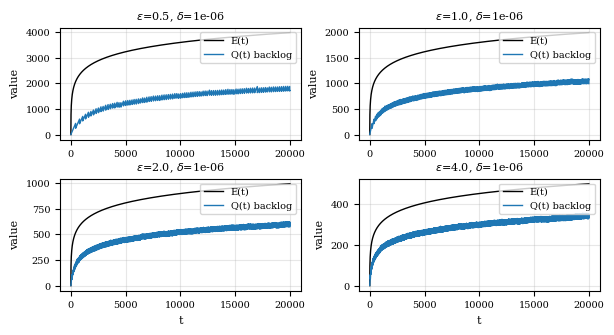

In [7]:
# ICML-style plot (one-column, 2x2) and save to PDF
import numpy as np
import matplotlib.pyplot as plt

# ICML-ish style settings
plt.rcParams.update({
    'font.size': 8,
    'font.family': 'serif',
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 1.0,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

T = 20000
stream = list(range(1, T + 1))
params = [
    (0.5, 1e-6),
    (1.0, 1e-6),
    (2.0, 1e-6),
    (4.0, 1e-6),
]

fig, axes = plt.subplots(2, 2, figsize=(6, 3.2), sharex=False, sharey=False)
axes = axes.flatten()

for ax, (eps, delt) in zip(axes, params):
    outputs, backlog = interactive_randbin(eps, delt, stream)
    Q = np.asarray(backlog, dtype=float)
    E = np.array([_E(t + 1, eps / 2.0, delt / 2.0) for t in range(T)], dtype=float)

    ax.plot(np.arange(1, T + 1), E, label='E(t)', color='black')
    ax.plot(np.arange(1, T + 1), Q, label='Q(t) backlog', color='tab:blue')
    ax.set_title(f'$\epsilon$={eps}, $\delta$={delt}')
    ax.set_ylabel('value')
    ax.legend(frameon=True, loc='upper right')

for ax in axes[-2:]:
    ax.set_xlabel('t')

plt.tight_layout(pad=0.2)

out_path = 'randbin_icml_plot_onecol_2x2.pdf'
plt.savefig(out_path, bbox_inches='tight')
print('Saved', out_path)
